Here we do a symlar diagonalization analysis that we did before but using a **non-hermitian hamiltonian**. We do
this to **add dissipation** to our system and try to inder a coherence length from it, in the style of the paper https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.L042031 

**Remember to renormalize the Hamiltonian again**

**Avoid the qubit site when plugging gamma**

**The broadening shhould be smaller than the energy gaps otherwise we dont resolve anything.**


In [3]:
import sys
sys.path.append('../scripts') 

import numpy as np
import pandas as pd
# from scipy.fft import fft, ifft, fftfreq
from tqdm import tqdm


#from scipy.integrate import simpson
# from scipy.interpolate import UnivariateSpline

import qutip
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  
from ast import literal_eval

In [4]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/perturbative/"
data_route = "../data/sims/L=21/"


# Functions

In [29]:
def create_hamiltonians(L, T, Bond, Gamma):
    # creates the decoupled and interacting hamiltonians 
    
    # L_qpc = qpc lattice sites
    # T = qubit hopping
    # Gamma = dissipation
    # BOnd = index for bond locatin
    H_matrix = np.zeros((2*L,2*L)) + 0j
    # fill the diagonal with dissipation
    d_indices= kth_diag_indices(H_matrix,0)
    H_matrix[d_indices] = -1j*Gamma
    # fill in the dd hopping 
    d_indices= kth_diag_indices(H_matrix,1)
    H_matrix[d_indices] = -T 
    
    # fill in the QPC hopping
    d_indices= kth_diag_indices(H_matrix,2)
    H_matrix[d_indices] = -J[0]
    
    # when qpc and qubit hop a the same time there is no contribution
    d_indices= kth_diag_indices(H_matrix,1)
    odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
    H_matrix[odd_inds] = 0
    
    # save the free hamiltonian for later use
    Hdeco = H_matrix.copy()
    
    # Fill in the interaction at the bond
    H_matrix[2*Bond,2*(Bond+1)] = H_matrix[2*Bond,2*(Bond+1)]+ Omega
    
    # Now the elemets below the diagonal
    for i in range(0,2*L):
        for j in range(i + 1, 2*L):
            H_matrix[j, i] = H_matrix[i, j]
            Hdeco[j, i] = Hdeco[i, j]
            
    return H_matrix, Hdeco

def get_spectral(Energies, Op = 10**(-5)):
    # calculates the spectral function of th hamiltonian Ham with infinithesimal Op for
    # regularization
    E_arr = np.linspace(min(Energies.real), max(Energies.real), 9000).real
    
    G_list = [] 
    for i in range(0,len(E_arr)):
        # I put the Op above purely for regularizing the result
        Gn = np.sum(1/(E_arr[i] - Energies + 1j*Op))
        G_list.append(Gn)
    # the boundaries frow way too fast because of the delta so we take them out
    
    return E_arr[1:-1] , -2*np.imag(G_list[1:-1])

# Diagonalizing

In [164]:
Omega = 0.4
J_prime = 1

L_qpc_list = [40] # qpc length
t_list = [0.05, 0.07 ,0.3,] # rabi oscillation
gamma_list = [0.001, 0.02, 0.04, 0.06, 0.1]  # add dissipation

ll_qpc = 40
print("perturbative threshold for t")
print(np.pi/(ll_qpc+1))
print("coherence threshlod for gamma")
print(1/ll_qpc)

perturbative threshold for t
0.07662421106316569
coherence threshlod for gamma
0.025


In [165]:
# create all parameter combinations
comb_array = np.array( np.meshgrid(L_qpc_list,t_list, gamma_list)).T.reshape(-1, 3) 

np.shape(comb_array)

(15, 3)

In [166]:
# for the dataset
data_dict = {"L_qpc" : [],"t":[],"gamma":[], "Omega" : [], "free_energies": [], "free_spectral" : [], "int_energies" : [], 
             "int_spectral" : [], "gamma_energies" : [], "gamma_spectral" : [] , "E_range" : []}

for simulation_index in tqdm(range(0,np.shape(comb_array)[0]), desc="Iterating Parameters"):
    parameter_array = comb_array[simulation_index,:]
    L_qpc = int(parameter_array[0])
    t = float(parameter_array[1])
    gamma = float(parameter_array[2])
    
    L = L_qpc + 2
    bond_index =  int(L_qpc/2)
    J = np.ones(L_qpc) # QPC hopping
    J[bond_index] = J_prime  

    # build the projection opeartor to the qubit-symmetric sector of the hilbert space
    Id_qpc = np.eye(L_qpc)
    plusket = np.asarray([1/np.sqrt(2),1/np.sqrt(2)])
    p_ketbra = np.outer(plusket,plusket)
    Psym = np.eye(2*L_qpc) - np.kron(Id_qpc, p_ketbra) # tensor product
    
    H_dissipative, _ = create_hamiltonians(L_qpc, t, bond_index, gamma)
    
    # Matrix withour dissipation
    H_interact, Hdeco = create_hamiltonians(L_qpc, t, bond_index, 0)
    
    # Calculate the energies and eigenvectors
    energies_gamma, vecs_gamma = np.linalg.eig(H_dissipative)
    vecs_gamma = vecs_gamma/ np.linalg.norm(vecs_gamma, axis=0)
    
    energies_int, vecs_int = np.linalg.eig(H_interact)
    vecs_int = vecs_int/ np.linalg.norm(vecs_int, axis=0)
    
    energies_free, vecs_free = np.linalg.eig(Hdeco)
    vecs_free = vecs_free/ np.linalg.norm(vecs_free, axis=0)
    
    # Sort into bands ---------------------------------------------------
    
    # sort the free evectros into bands according to their projection
    mindices, pindices = sort_by_projection(energies_free,vecs_free, Psym)
    
    # minus band
    free_energies_m = energies_free[mindices]
    free_states_m = vecs_free[:,mindices]
    # sort by magnitude
    free_energies_m, free_states_m = mag_sort(free_energies_m, free_states_m)
    
    # plus band
    free_energies_p = energies_free[pindices]
    free_states_p = vecs_free[:,pindices]
    # sort by magnitude
    free_energies_p, free_states_p = mag_sort(free_energies_p, free_states_p)
    
    
    # sort by their overlaps with the free, nondissipative case
    sorted_indices, over_matrix = sort_by_overlap_matrix(energies_int, vecs_free,vecs_int)
    sorted_e = energies_int[sorted_indices]
    sorted_vecs = vecs_int[:,sorted_indices]
    
    int_energies_m = sorted_e[mindices]
    int_states_m = sorted_vecs[:,mindices]
    int_energies_m, int_states_m = mag_sort(int_energies_m, int_states_m)
    
    int_energies_p = sorted_e[pindices]
    int_states_p = sorted_vecs[:,pindices]
    int_energies_p, int_states_p = mag_sort(int_energies_p, int_states_p)
    
    # sort by their overlaps with the free, nondissipative case
    sorted_indices, over_matrix = sort_by_overlap_matrix(energies_gamma, vecs_free,vecs_gamma)
    sorted_e = energies_gamma[sorted_indices]
    sorted_vecs = vecs_gamma[:,sorted_indices]
    gamma_energies_m = sorted_e[mindices]
    gamma_states_m = sorted_vecs[:,mindices]
    gamma_energies_m, int_states_m = mag_sort(gamma_energies_m, gamma_states_m)
    
    gamma_energies_p = sorted_e[pindices]
    gamma_states_p = sorted_vecs[:,pindices]
    gamma_energies_p, gamma_states_p = mag_sort(gamma_energies_p, gamma_states_p)
    
    e_arr, spectral_free = get_spectral( energies_free)
    _, spectral_int = get_spectral(energies_int)
    _, spectral_gamma = get_spectral(energies_gamma)

    data_dict["t"].append(t)
    data_dict["gamma"].append(gamma)
    data_dict["L_qpc"].append(L_qpc)
    data_dict["Omega"].append(Omega)

    data_dict["free_energies"].append(energies_free)
    data_dict["free_spectral"].append(spectral_free)
    data_dict["int_energies"].append(energies_int)
    data_dict["int_spectral"].append(spectral_int)
    data_dict["gamma_energies"].append(energies_gamma)
    data_dict["gamma_spectral"].append(spectral_gamma)
    data_dict["E_range"].append(e_arr)



Iterating Parameters: 100%|█████████████| 15/15 [00:03<00:00,  4.16it/s]


In [167]:

lengths = {key: len(value) for key, value in data_dict.items()}

lengths

{'L_qpc': 15,
 't': 15,
 'gamma': 15,
 'Omega': 15,
 'free_energies': 15,
 'free_spectral': 15,
 'int_energies': 15,
 'int_spectral': 15,
 'gamma_energies': 15,
 'gamma_spectral': 15,
 'E_range': 15}

# Broadening of the DOS

for each energy band

In [168]:
data_df = pd.DataFrame.from_dict(data_dict)

print(data_df["t"].unique())
print(data_df["gamma"].unique())

data_df.head()

[0.05 0.07 0.3 ]
[0.001 0.02  0.04  0.06  0.1  ]


,L_qpc,t,gamma,Omega,free_energies,free_spectral,int_energies,int_spectral,gamma_energies,gamma_spectral,E_range
0,40,0.05,0.001,0.4,"[(2.0441316023674734-0j), (2.0265608475606958+...","[96.94554734128883, 24.315732541359804, 10.863...","[(-2.0362273609689194+0j), (-2.026404568076744...","[97.8584217949869, 24.68388623357486, 11.15060...","[(-2.036227360968915-0.0009999999999999996j), ...","[1673.9518432774844, 1125.4478964462296, 735.4...","[-2.0436773004222917, -2.043222998477105, -2.0..."
1,40,0.07,0.001,0.4,"[(2.064131602367479+0j), (-2.0641316023674885+...","[95.07622400776444, 23.84632188438915, 10.6536...","[(-2.055859947656831+0j), (-2.0463760906948734...","[96.0187922613344, 24.23790795243122, 10.96624...","[(-2.055859947656833-0.0009999999999999955j), ...","[1670.0839197574314, 1117.8119352005297, 728.8...","[-2.063672855483975, -2.0632141086004623, -2.0..."
2,40,0.30,0.001,0.4,"[(2.294131602367486-0j), (2.2765608475606935+0...","[76.98854793206264, 19.319864054087954, 8.6409...","[(-2.284779746234471+0j), (-2.2762833077033626...","[77.86296568099418, 19.76107127564242, 9.04372...","[(-2.284779746234473-0.0009999999999999979j), ...","[1613.2222731655345, 1021.5304757975592, 646.8...","[-2.2936217386932087, -2.293111875018941, -2.2..."
3,40,0.05,0.020,0.4,"[(2.0441316023674734-0j), (2.0265608475606958+...","[96.94554734128883, 24.315732541359804, 10.863...","[(-2.0362273609689194+0j), (-2.026404568076744...","[97.8584217949869, 24.68388623357486, 11.15060...","[(-2.0362273609689185-0.019999999999999976j), ...","[219.8541775905833, 221.5311640818162, 223.091...","[-2.0436773004222917, -2.043222998477105, -2.0..."
4,40,0.07,0.020,0.4,"[(2.064131602367479+0j), (-2.0641316023674885+...","[95.07622400776444, 23.84632188438915, 10.6536...","[(-2.055859947656831+0j), (-2.0463760906948734...","[96.0187922613344, 24.23790795243122, 10.96624...","[(-2.0558599476568302-0.020000000000000014j), ...","[215.73474900907027, 217.3502411370789, 218.84...","[-2.063672855483975, -2.0632141086004623, -2.0..."


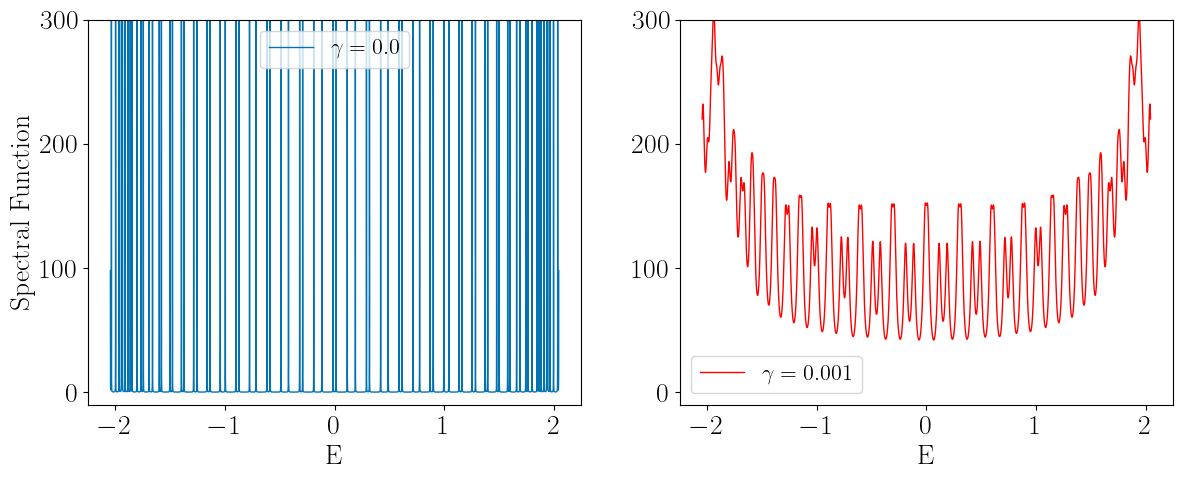

In [169]:
# comparing with non dissipative case
cond = (data_df["t"]==0.05) & (data_df["gamma"]==0.02)

E_range = data_df[cond]["E_range"].values[0]
gamma_spectral = data_df[cond]["gamma_spectral"].values[0]
int_spectral = data_df[cond]["int_spectral"].values[0]


fig, ax = plt.subplots(1,2, figsize=(2*bwidth, bheight))
ax[0].plot(E_range, int_spectral , linewidth = 1,  label = r"$\gamma=0.0$" )
ax[1].plot(E_range,gamma_spectral, c="red", linewidth = 1,
           label = r"$\gamma={}$".format(data_dict["gamma"][index_]) )

ax[0].set_xlabel("E")
ax[0].set_ylabel("Spectral Function")
ax[0].set_ylim(-10,300)
ax[0].legend()

ax[1].set_xlabel("E")
ax[1].set_ylim(-10,300)
ax[1].legend()



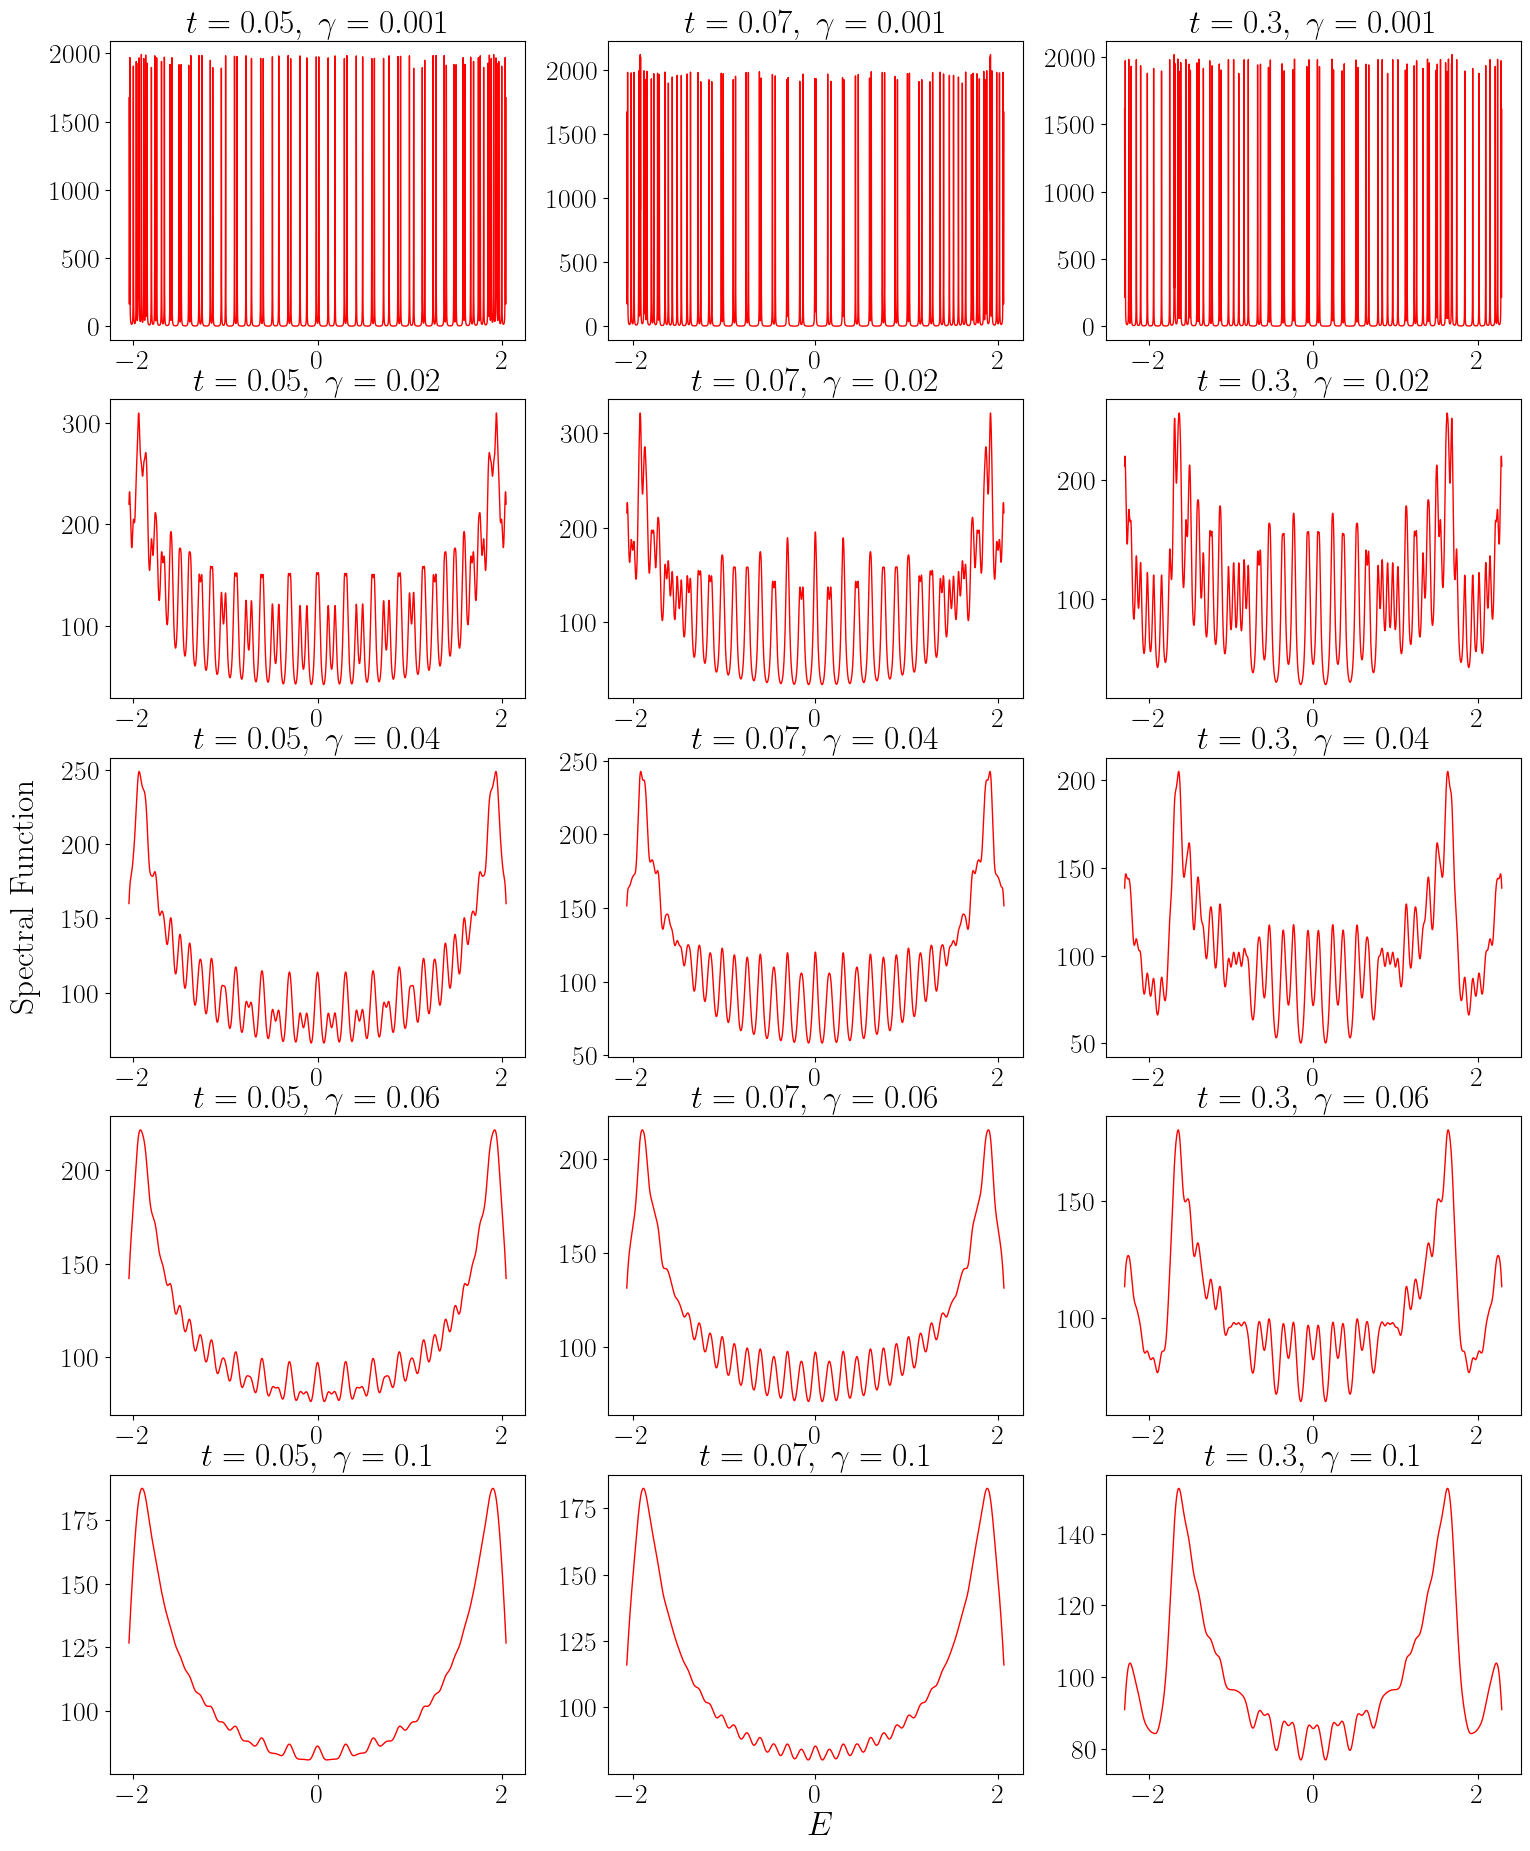

In [170]:
nrows = data_df["gamma"].nunique()
ncols = data_df["t"].nunique()

t_vals = data_df["t"].unique()
gamma_vals = data_df["gamma"].unique()

fig, ax = plt.subplots(nrows,ncols, figsize=(2.6*bwidth, 4.5*bheight))

for row_ in range(0,nrows):
    for col_ in range(0,ncols): 
        cond = (data_df["t"]==t_vals[col_]) & (data_df["gamma"]==gamma_vals[row_])
        E_range = data_df[cond]["E_range"].values[0]
        gamma_spectral = data_df[cond]["gamma_spectral"].values[0]
                
        ax[row_, col_].plot(E_range, gamma_spectral, c="red", linewidth = 1)
        ax[row_, col_].set_title(r"$t = {},  \; \gamma = {}$".format(t_vals[col_], gamma_vals[row_]))

fig.supylabel("Spectral Function", x=0.07)
fig.supxlabel(r"$E$",x=0.515,y=0.08)

plt.savefig(fig_route+"spectral_broadening_Lqpc={}.pdf".format(L_qpc_list[0]),bbox_inches='tight')